## Climate Central altimetry data

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import xarray as xr
from skimage import io
import subprocess

from osgeo import gdal
import rasterio

import cartopy.feature as cf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
import cartopy.feature as cf
from cartopy.util import add_cyclic_point

# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

## General information:

* Horizontal Datum: WGS84
* Vertical Datum: EGM96
* No data value (outside of spatial domain): -9999
* No data value (where NASADEM is missing data): -32767

Climate Central SRTM collected topographic data : Shuttle Radar Topography Mission  

* Source https://sealevel.climatecentral.org/uploads/research/Global-Mapping-Choices-Report.pdf
* How to convert EGM96 to mean sea level?
*  "Tideline" is used to denote the highest daily local tide level or, technically, the mean higher high water (MHHW) line. 
* Within the United States, NOAA's VDatum tool is used for MHHW values; elsewhere, modeled tidal increments are added to recent historical average sea surface heights measured by satellite. Tideline projections add projected sea level rise.

## make simple plot of single tile

In [5]:
fp_home = '/Users/annalea_albright/Dropbox/BPCE/Data/coastaldemv2/'
#fp = os.path.join(fp_home, 'N42E003.tif')
fp = os.path.join(fp_home, 'N48W005.tif')

In [6]:
dataset = gdal.Open(fp)
print(dataset.RasterCount)

1


min value -2.581092119216919
max value 325.0


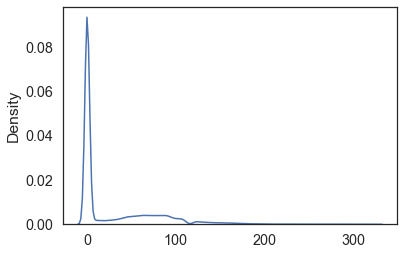

In [11]:
img = io.imread(fp)

print('shape of file', img.shape)
print('min value', img.min())
print('max value', img.max())

if 0:
    sns.kdeplot(img.flatten())
    sns.despine()

In [4]:
def plot_tif_file(fp):
    img = io.imread(fp)
    ax = plt.subplot()
    im = ax.imshow(img, cmap="gray")
    #print(img))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax, label="elevation (m)")
    #plt.axis('off')

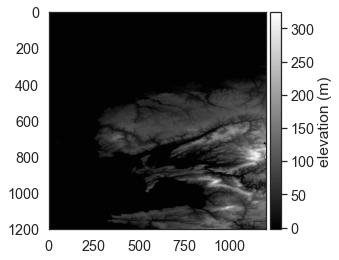

In [5]:
fp_home = '/Users/annalea_albright/Downloads/coastaldemv2/'
#fp = os.path.join(fp_home, 'N42E003.tif')
fp = os.path.join(fp_home, 'N48W005.tif')

plot_tif_file(fp)

### Another way of opening using rasterio

In [137]:
ds = rasterio.open(fp)
data=ds.read()
print(data.shape)

(1, 1201, 1201)


In [140]:
# https://gis.stackexchange.com/questions/428728/get-lanlon-and-values-from-geotiff-using-python
import rasterio
import rasterio.features
import rasterio.warp

with rasterio.open(fp) as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()
    
    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):
    
        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=8) 
print(geom)
#print(mask)

{'type': 'Polygon', 'coordinates': [[[-5.0, 49.0], [-5.0, 48.0], [-4.0, 48.0], [-4.0, 49.0], [-5.0, 49.0]]]}


# Merging tif files

In [111]:
# probably a nicer way of merging all of these files

l1 = glob.glob("/Users/annalea_albright/Dropbox/BPCE/Data/coastaldemv2/N4[2-9]W00[0-6]*.tif")
l2 = glob.glob("/Users/annalea_albright/Dropbox/BPCE/Data/coastaldemv2/N4[2-9]E00[0-7]*.tif")
l3 = glob.glob("/Users/annalea_albright/Dropbox/BPCE/Data/coastaldemv2/N5[0-1]*00[0-5]*.tif")

demList = l1 + l2 + l3
print('number of files:', len(demList))
#print(demList)

number of files: 71


## Do the merging and save file

In [112]:
files_to_mosaic = demList 
fp_save = "/Users/annalea_albright/Dropbox/BPCE/Data/output.tif"
g = gdal.Warp(
                fp_save, 
              files_to_mosaic, 
              format="GTiff",
              options=["COMPRESS=LZW", "TILED=YES"]
             ) # if you want
g = None # Close file and flush to disk

## Test opening the file

In [12]:
fp_save = "/Users/annalea_albright/Dropbox/BPCE/Data/output.tif"
img = io.imread(fp_save)

In [ ]:
print(img)

print('shape of file', img.shape)
print('min value', img.min())
print('max value', img.max())

''' compare minimum with no data value... 
No data value (outside of spatial domain): -9999
No data value (where NASADEM is missing data): -32767
 '''

if 0:
    sns.kdeplot(img.flatten())

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
shape of file (12010, 16814)
min value -186.0
max value 2900.0


## Plot

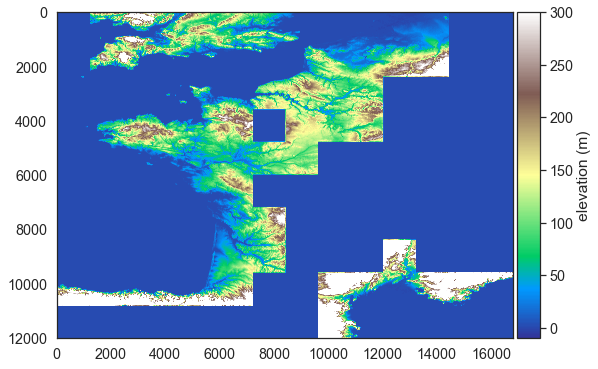

In [7]:
plt.figure(figsize=(10, 6)) 
ax = plt.subplot(1, 1, 1)  #
im = ax.imshow(img, cmap="terrain", # gray
              vmin=-10, vmax=300)
#print(img))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label="elevation (m)")

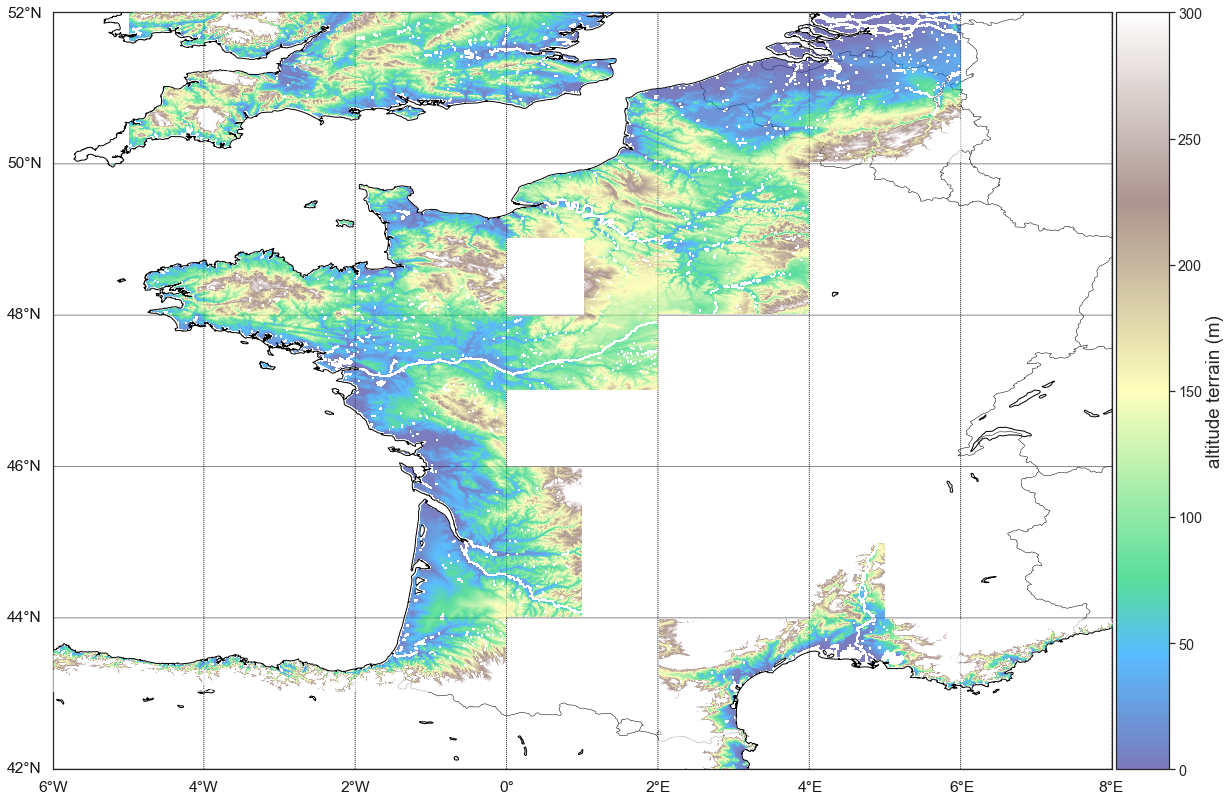

In [19]:
# https://stackoverflow.com/questions/45677300/how-to-plot-geotiff-data-in-specific-area-lat-lon-with-python
import georaster
from mpl_toolkits.basemap import Basemap


fp =  "/Users/annalea_albright/Dropbox/BPCE/Data/output.tif"

# read extent of image without loading
# good for values in degrees lat/long
# geotiff may use other coordinates and projection
my_image = georaster.SingleBandRaster(fp, load_data=False)

# grab limits of image's extent
minx, maxx, miny, maxy = my_image.extent

# load the geotiff image, assign it a variable
image = georaster.SingleBandRaster( fp, \
                        load_data=(minx, maxx, miny, maxy), \
                        latlon=True)

im_array = image.r

# value of 1 for oceans, lakes, reservoirs, etc
im_array[im_array == 1.000] = np.nan

# plot
fig, ax = plt.subplots(figsize=(20,20))

offset = 0
# set Basemap with slightly larger extents
# set resolution at intermediate level "i"
m = Basemap( projection='cyl', \
            llcrnrlon=minx-offset, \
            llcrnrlat=miny-offset, \
            urcrnrlon=maxx+offset, \
            urcrnrlat=maxy+offset, \
            resolution='h')

m.drawcoastlines(color="black")
m.drawcountries(color="black")
#m.fillcontinents(color='white')

m.drawmeridians(range(-10, 10, 2), labels=[False, False, False, True])
m.drawparallels(range(40, 53, 2), labels=[True, False, False, False])

im = plt.imshow(
                im_array,  # array values 
                extent=(minx, maxx, miny, maxy), 
                vmin=0,
                vmax=300,
                zorder=10, 
                alpha=0.65,
               cmap="terrain", # terrain, plasma
          )

if 0:
    plt.scatter(
        location_data.lon.values,
        location_data.lat.values,
        color="black",
        s=200,
        zorder=11,
    )

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax, )
cb.set_label(label="altitude terrain (m)", size='large', 
             #weight='bold'
            )


## Extra

In [26]:
# Open the GeoTIFF file
from osgeo import osr

# Open the GeoTIFF file
dataset = gdal.Open(fp)

# Get the spatial reference system (SRS) from the GeoTIFF
srs = osr.SpatialReference()
srs.ImportFromWkt(dataset.GetProjection())

# Extract the EPSG code from the SRS
epsg_code = srs.GetAttrValue('AUTHORITY', 1)

print("EPSG code:", epsg_code)

EPSG code: 4326
